In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import ops
import struct
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
from array import array
from os.path  import join
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
#allocatig data
x,y = mnist['data'],mnist['target']

x_train,x_test = x[:60000], x[60000:]
y_train,y_test = y[:60000], y[60000:]

x_train =jnp.array(x_train, dtype=jnp.int32)
x_test = jnp.array(x_test,dtype = jnp.int32)
y_train = jnp.array(y_train,dtype = jnp.int32)
y_test = jnp.array(y_test,dtype=jnp.int32)

In [3]:
#loading data on gpu
if jax.devices("gpu"):
    gpu_device = jax.devices("gpu")[0]

    x_train = jax.device_put(x_train, device=gpu_device)
    y_train = jax.device_put(y_train, device=gpu_device)
    x_test = jax.device_put(x_test, device=gpu_device)
    y_test = jax.device_put(y_test, device=gpu_device)
else:
    print("No GPU devices found.")


In [4]:
x_train = jnp.transpose(jnp.reshape(x_train, (60000, -1)))
x_test = jnp.transpose(jnp.reshape(x_test, (10000, -1)))
y_train = jnp.reshape(y_train, (1, 60000))
y_test = jnp.reshape(y_test, (1, 10000))

In [5]:
#ormalising data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
def ReLU(x):
  #inputs linear units
  #outputs non-linear units
  #outputs positive number ass it is or outputs 0
  y = jnp.maximum(0, x)
  return y

def softmax(x):
  #Used when more than 2 class-classification is involved in this case 10

  exp_x = jnp.exp(x) #coverts all values into positive; amplifies diferences in values
  sum_exp_x = jnp.sum(exp_x, axis=0, keepdims=True) #axis =0 calculated along rows, keepdims = true dimension same as exp_x
  y = exp_x / sum_exp_x
  return y


In [7]:
def initialize_params():
  #geerating matrix of random values for Weights and matrix of random values for biases
  key = random.PRNGKey(0)
  W1 = random.normal(key, (36, 784))*0.01
  W2 = random.normal(key, (10, 36))*0.01
  b1 = jnp.zeros((36, 1))
  b2 = jnp.zeros((10, 1))
  return W1, b1, W2, b2

In [8]:
def forward_prop(W1,b1,W2,b2,X) :
  #inputs W1 , b1 - weight matrix and bias matrix for first layer
  #inputs W2,  b2 - weight matrix and bias matrix for second layer
  #inputs X - activation function of initial layer
  Z1 = jnp.dot(W1, X) + b1
  A1 = ReLU(Z1)
  Z2 = jnp.dot(W2,A1) + b2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

In [9]:
def calculate_cost(A2, Y):
  #inputs A2- output of forward propogation
  #inputs Y- list of correct predictions of model
  #claculated using BINARY CROSS ENTROPY LOSS
  # Elementwise multiplication of Y and log(A2) : if Y is 1, then A2 must be close to ! or the function will give large value of cost
  #Similarly (1-Y)*log(1-A2) is for when Y is 0
  #Dividing len(Y)- to find average of the function : len(Y)- number of elements in list Y
  cost = -jnp.sum(Y * jnp.log(A2) + (1 - Y) * jnp.log(1 - A2)) / len(Y)
  return cost


In [10]:
def one_hot(Y):
  #Y- array of class lael containing correct labels
  #computing number of samples in dataset
  Y_size = jnp.size(Y)
  #calculating number of unique class in dataset
  Y_max = jnp.max(Y)
  #making a matrix of zeros with number of columns - number of classes; number of rows- number of dataset
  one_hot_Y = jnp.zeros((Y_size, Y_max + 1), dtype=jnp.int32)
  #sets 0 to 1 at row-jnp.arange(Y_size); column - Y
  one_hot_Y=one_hot_Y.at[jnp.arange(Y_size), Y].set(1)
  one_hot_Y = jnp.transpose(one_hot_Y)
  return one_hot_Y


In [11]:
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
  m = Y.size
  one_hot_Y = one_hot(Y)
  #derivative of loss
  dZ2 = A2 - one_hot_Y
  #calculatig derivatives
  dW2 = 1/m * jnp.dot(dZ2,jnp.transpose(A1))
  db2 = 1/m * jnp.sum(dZ2, axis =1, keepdims = True)
  dZ1 = jnp.dot(jnp.transpose(W2), dZ2) * deriv_ReLU(Z1)
  dW1 = 1/m * jnp.dot(dZ1,jnp.transpose(X))
  db1 = 1/m * jnp.sum(dZ1,axis = 1, keepdims = True)
  return dW1, db1, dW2, db2

In [12]:
def deriv_ReLU(z):
  #taking derivative for back-prop
  return z>0

In [13]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
#updating params to pass them into forward prop to increase accuracy
  W1 = W1 - alpha*dW1
  W2 = W2 - alpha*dW2
  b1 = b1 - alpha*db1
  b2 = b2 - alpha*db2
  return W1, b1, W2, b2

In [14]:
def calculate_predictions(A2):
  #calculates maximum value along row of each column
  y= jnp.argmax(A2, axis=0)
  return y

In [15]:
def calculate_accuracy(predictions, Y):
  #returns true if predictions matches the correct predictions of dataset; sums the total number of true we get
  num = jnp.sum(predictions == Y)
  #ratio of total number of trues and total number of predictions
  accuracy = (num / jnp.size(Y))*100
  print(predictions, Y)
  return accuracy

In [23]:
def result(X, Y, iterations, alpha):
  #initialising weights and biases
  W1, b1, W2, b2 = initialize_params()

  iteration_values = []  # To store iteration values
  cost_values = []      # To store cost values
  accuracy_values = []  # To store accuracy values


  for i in range(0, iterations):
    #initialisind a list to contain cost values
    costs = []
    #calculating forward propogation
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    #calculatig cost
    cost = calculate_cost(A2, one_hot(Y))
    #ackward propogation
    dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
    #updating parameters
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
    if i%100 == 0:
      print("At iteration " + str(i) + "the cost is " + str(cost))
      iteration_values.append(i)
      cost_values.append(cost)
    if i % 100 == 0 or i == iterations:
      print("Iterations: " + str(i))
      accuracy = calculate_accuracy(calculate_predictions(A2), Y)
      print("Accuracy  :" + str(accuracy))
      accuracy_values.append(accuracy)
  return cost , iteration_values, cost_values, accuracy_values

At iteration 0the cost is 19504.91
Iterations: 0
[8 3 8 ... 8 3 8] [[5 0 4 ... 5 6 8]]
Accuracy  :7.545
At iteration 100the cost is 5699.387
Iterations: 100
[3 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :85.113335
At iteration 200the cost is 3870.2148
Iterations: 200
[3 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :89.405
At iteration 300the cost is 3367.0037
Iterations: 300
[3 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :90.56
At iteration 400the cost is 3098.329
Iterations: 400
[5 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :91.31167
At iteration 500the cost is 2914.5745
Iterations: 500
[5 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :91.86667
At iteration 600the cost is 2770.5127
Iterations: 600
[5 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :92.24333
At iteration 700the cost is 2646.942
Iterations: 700
[5 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :92.61
At iteration 800the cost is 2534.552
Iterations: 800
[5 0 4 ... 5 6 8] [[5 0 4 ... 5 6 8]]
Accuracy  :92.98334
At iteratio

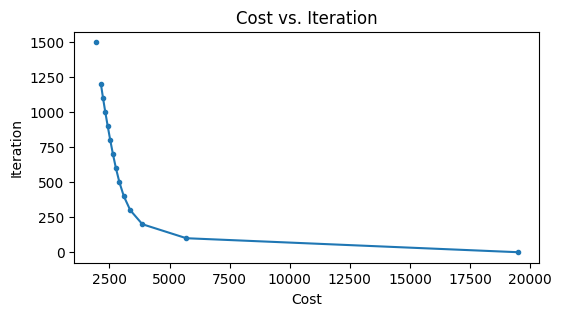

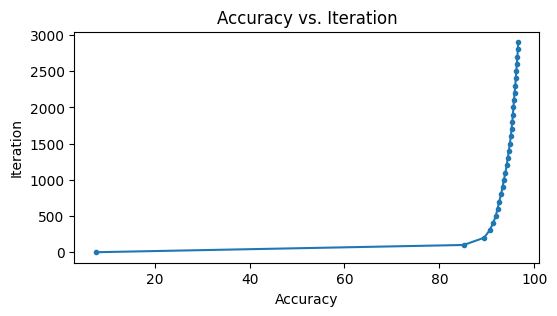

In [29]:
cost,iteration_values, cost_values, accuracy_values  = result(x_train, y_train, 3000, 0.2)

import matplotlib.pyplot as plt
# Create a plot
plt.figure(figsize=(6,3))
plt.plot(cost_values, iteration_values, marker='.', linestyle='-')

# Set labels and title
plt.xlabel('Cost')
plt.ylabel('Iteration')
plt.title('Cost vs. Iteration')

# Show the plot

plt.show()

plt.figure(figsize=(6,3))
plt.plot(accuracy_values, iteration_values, marker='.', linestyle='-')

# Set labels and title
plt.xlabel('Accuracy')
plt.ylabel('Iteration')
plt.title('Accuracy vs. Iteration')

# Show the plot

plt.show()
